In [158]:
import numpy as np
import pandas as pd
import pulp
import itertools
import gmaps
import googlemaps

In [159]:
API_KEY = 'ENTER_YOUR_API'
gmaps.configure(api_key=API_KEY)
googlemaps = googlemaps.Client(key=API_KEY)

In [160]:
# customer count ('0' is depot)
customer_count = int(input('Enter number of customers: '))

# the number of vehicle
vehicle_count = int(input('Enter number of vehicles: '))

# the capacity of vehicle
vehicle_capacity = 50

# fix random seed
np.random.seed(seed=7)

# set depot latitude and longitude
# 43.34622573712328, 76.97812881726297
depot_latitude = float(input('Enter the latitude of the Depot: ')) 
depot_longitude = float(input('Enter the longitude of the Depot: ')) 

Enter number of customers:  10
Enter number of vehicles:  4
Enter the latitude of the Depot:  43.34622573712328
Enter the longitude of the Depot:  76.97812881726297


In [161]:
# make dataframe which contains vending machine location and demand
sigma = 0.25
df = pd.DataFrame({"latitude":np.random.normal(depot_latitude, sigma, customer_count),
                   "longitude":np.random.normal(depot_longitude, sigma, customer_count),
                   "demand":np.random.randint(10, 20, customer_count)})

# set the depot as the center and make demand 0 ('0' = depot)
df.iloc[0,0] = depot_latitude
df.iloc[0,1] = depot_longitude
df.iloc[0,2] = 0
df

,latitude,longitude,demand
0,43.346226,76.978129,0
1,43.313610,76.966120,19
2,43.348523,77.013500,17
3,43.374752,76.959834,13
4,43.291001,76.961136,13
5,43.346370,76.876402,18
6,43.346163,77.016949,13
7,43.223395,76.986800,10
8,43.417462,76.997341,11
9,43.388261,76.871272,10


In [162]:
# function for calculating distance between two pins
def _distance_calculator(_df):

    _distance_result = np.zeros((len(_df),len(_df)))
    _df['latitude-longitude'] = '0'
    for i in range(len(_df)):
        _df['latitude-longitude'].iloc[i] = str(_df.latitude[i]) + ',' + str(_df.longitude[i])

    for i in range(len(_df)):
        for j in range(len(_df)):

            # calculate distance of all pairs
            _google_maps_api_result = googlemaps.directions(_df['latitude-longitude'].iloc[i],
                                                            _df['latitude-longitude'].iloc[j],
                                                            mode = 'driving')
            # append distance to result list
            _distance_result[i][j] = _google_maps_api_result[0]['legs'][0]['distance']['value']

    return _distance_result

In [163]:
df_copy = df.copy()
distance = _distance_calculator(df_copy)

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [164]:
# solve with pulp
for vehicle_count in range(1,vehicle_count+1):

    # definition of LpProblem instance
    problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

    # definition of variables which are 0/1
    x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]

    # add objective function
    # minimize the travel cost (sum of traveling distance) of all vehicles
    problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                          for k in range(vehicle_count)
                          for j in range(customer_count)
                          for i in range (customer_count))

    # constraints
    # 1: only one visit per vehicle per customer’s location
    for j in range(1, customer_count):
        problem += pulp.lpSum(x[i][j][k] if i != j else 0
                              for i in range(customer_count)
                              for k in range(vehicle_count)) == 1

    # 2: depart from depot
    for k in range(vehicle_count):
        problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
        problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

    # 3: the number of vehicles coming in and out of a customer’s location is the same
    for k in range(vehicle_count):
        for j in range(customer_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

    # 4: the delivery capacity of each vehicle should not exceed the maximum capacity
    for k in range(vehicle_count):
        problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity


    # 5: removal of subtours
    subtours = []
    for i in range(2,customer_count):
         subtours += itertools.combinations(range(1,customer_count), i)

    for s in subtours:
        problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1


    # print vehicle_count which needed for solving problem
    # print calculated minimum distance value
    if problem.solve() == 1:
        print('Vehicle Requirements:', vehicle_count)
        print('Moving Distance:', pulp.value(problem.objective))
        break

Vehicle Requirements: 3
Moving Distance: 125943.0


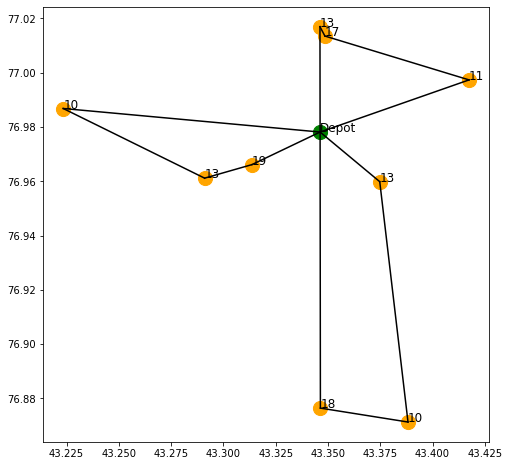

In [165]:
import matplotlib.pyplot as plt
# visualization : plotting with matplolib
plt.figure(figsize=(8,8))
for i in range(customer_count):
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
        plt.text(df.latitude[i], df.longitude[i], "Depot", fontsize=12)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
        plt.text(df.latitude[i], df.longitude[i], str(df.demand[i]), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")

plt.savefig('distances.png',bbox_inches='tight')
plt.show()